In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import KFold

In [62]:
df = pd.read_csv('/picstorage/last_reports.csv')

In [63]:
df = df.drop('Unnamed: 0',axis=1)

In [64]:
df.head()

,school,text,file,label
0,Oldfield School Closed,26/04/2011 Dear Parent Oldfield Sch...,1560129,last
1,Settle Church of England Voluntary Controlled ...,School report Settle Church of England Volunt...,2542866,last
2,Whitmore Park Annexe Closed,School report Whitmore Park Annexe Rylst...,50051929,last
3,Da Vinci Community School Closed,Ofsted Piccadilly Gate Store Street Manchester...,2559726,last
4,Amazing Allstars Out Of School Club Closed,Amazing Allstars Out Of School Club 2nd...,2732121,last


In [65]:
len(df[df['label'] == 'not_last'])
not_last = df[df['label'] == 'not_last']

227183

In [66]:
len(df[df['label'] == 'last'])
last = df[df['label'] == 'last']

62556

In [68]:
# for a balanced dataset
not_last_sample = not_last.sample(1000)
last_sample = last.sample(1000)

In [70]:
subset = pd.concat([not_last_sample,last_sample],ignore_index=True)

In [71]:
# for an imbalanced dataset
# subset = df.sample(2000)
train = subset.sample(1500)
test = subset[~subset.isin(train)].dropna()
test['file'] = test['file'].astype(int)

In [3]:
# train.to_csv('/picstorage/lr_train_sample_even.csv',index=False)
train = pd.read_csv('/picstorage/last_report_train_sample.csv')
train = train.drop('Unnamed: 0',axis=1)
train.head()

,school,text,file,label
0,Denholme Primary School Closed,Denholme Primary School Inspection report ...,1964405,not_last
1,North Cornwall Short Stay School Closed,OfstedPage 1 of 5Tribal Group1-4 Portland Squa...,858483,not_last
2,Glenwood School,UntitledGlenwood SchoolInspection report115469...,926591,not_last
3,"Salisbury, Manor Fields Primary School",Manor Fields Primary SchoolInspection report.■...,974545,not_last
4,St Ambrose Catholic Primary School,St Ambrose Catholic Primary School Inspecti...,1975093,not_last


In [4]:
test = pd.read_csv('/picstorage/last_report_test_sample.csv')
test = test.drop('Unnamed: 0',axis=1)
test.head()

,school,text,file,label
0,URN: SC412705,Unique reference number SC412705 Vis...,2416777,not_last
1,Fig Tree Primary School,School report Fig Tree Primary School 30...,2734435,not_last
2,Askham Bar Day Nursery,Askham Bar Day N...,1796701,not_last
3,Victoria Road Primary School,School report Victoria Road Primary School...,2243241,not_last
4,Barnkids Ltd,Barnkids Ltd Ins...,1824169,not_last


In [77]:
test.to_csv('/picstorage/lr_test_sample_even.csv',index=False)

In [18]:
print ("printing len of train: {}".format(len(train)))
print ("printing len of test: {}".format(len(test)))

printing len of train: 1500
printing len of test: 500


In [11]:
print ("printing last reports in train: {}".format(len(train[train['label'] == 'last'])))
print ("printing not last reports in train: {}".format(len(train[train['label'] != 'last'])))
print ("printing last reports in test: {}".format(len(test[test['label'] == 'last'])))
print ("printing not last reports in test: {}".format(len(test[test['label'] != 'last'])))

printing last reports in train: 307
printing not last reports in train: 1193
printing last reports in test: 105
printing not last reports in test: 395


In [5]:
np.random.seed(42)
data_lm = load_data('/picstorage/', 'data_lm.pkl', bs=12)

/tmp/yes/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
bs=12

In [7]:
data_lm.show_batch()

idx,text
0,school total xxmaj government funded early educationprovision for aged to endof xxup eyfs xxmaj childcare provision for aged to yearsthe erning bodyappropriate authoritybarrie keastchakeith purvisheadteachernot previously inspecteddate of previous xxmaj not previously inspecteddate of previous funded early education xxmaj not previously inspecteddate of previous childcare xxmaj bank roadschool addresspilningbristolbs xxup jg xxmaj telephone number xxmaj fax number xxmaj age group xxmaj october xxmaj inspection dates xxmaj inspection number xxmaj crown
1,is clear guidance for everyone participating in activities and thisensures that focus and intentions are similar and shared xxmaj all six areas of are thoroughly covered xxmaj staff work hard to create realistic links between xxunk that can explore an idea in many different contexts xxmaj consequently understanding is greatly enhanced xxmaj early in year much of revolves around imaginative role play xxmaj later in year for part of each
2,xxunk on a xxmaj wednesday session is extended to enable to bring lunch xxmaj the nursery is able to use adjoining vicarage garden for outdoor play xxmaj there are two full time and six part time working with xxmaj two members have relevant child care qualifications and two are currently ontraining programmes xxmaj how is xxmaj day xxmaj care xxmaj the xxmaj greenery xxmaj nursery xxmaj school provides care for
3,adult and that y will be sorted quickly xxmaj nearly all comment that re is no bullying in xxmaj the very few who commented that bullying sometimes happens are adamant that teachers are really at resolving it xxmaj this means that enjoy time at and all stated that y would recommend to a friend moving to area xxmaj parents are confident that are kept safe and are extremely well looked
4,at home xxmaj partnerships with parents are very xxmaj parents comment on positive changes since last xxmaj staff provide an effective range of appropriately challenging experiences xxmaj children s confidence is nurtured and is extended when y are ready xxmaj they make progress from when y begin to attend xxmaj staff get to know individual extremely well xxmaj the key person system is highly effective xxmaj children share strong emotional


In [8]:
gc.collect()

74

In [9]:
data_clas = TextClasDataBunch.from_df(path='', train_df=train, valid_df=test, vocab=data_lm.vocab, 
                                       text_cols='text', label_cols='label')

In [19]:
data_clas.save('/picstorage/data_clas.pkl')

In [13]:
data_clas = load_data('', '/picstorage/data_clas.pkl', bs=bs)

In [14]:
data_clas.show_batch()

text,target
xxbos xxup xxunk xxup xxunk xxup woods xxunk xxunk londonlea area xxunk xxunk xxunk reference number xxunk xxunk xxunk xxmaj michael xxunk inspector xxunk xxmaj brian xxunk of inspection xxunk 7 xxunk xxunk xxmaj october xxunk number xxunk xxunk inspection carried out under section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non,not_last
xxbos xxup xxunk xxup xxunk xxup community xxunk area xxunk cornwallunique reference number xxunk xxunk xxunk xxmaj miss xxmaj janet xxunk inspector xxunk xxmaj john xxunk of inspection xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part for non xxunk commercial,not_last
xxbos xxup xxunk xxup report xxup princes xxup xxunk xxup school xxmaj princes xxmaj xxunk xxup lea area xxunk xxmaj xxunk xxmaj unique reference number xxunk xxunk xxmaj acting xxmaj headteacher xxunk xxmaj mrs s xxmaj gates xxmaj lead inspector xxunk xxmaj mrs j xxmaj greenfield xxmaj dates of inspection xxunk xxunk xxunk xxunk xxmaj september xxunk xxmaj inspection number xxunk xxunk xxmaj inspection carried out under section xxunk of,not_last
xxbos xxup xxunk xxup inspection xxup report xxup xxunk xxup primary xxup school xxmaj xxunk xxunk xxmaj nr xxmaj melton xxmaj mowbray xxup lea area xxunk xxmaj xxunk xxmaj unique reference number xxunk xxunk xxmaj headteacher xxunk xxmaj mrs a xxmaj wright xxmaj reporting inspector xxunk xxmaj mrs h xxmaj xxunk xxunk xxmaj dates of inspection xxunk xxmaj july xxunk xxunk xxunk xxunk xxmaj inspection number xxunk xxunk xxmaj inspection,not_last
xxbos xxup xxunk xxup reportthe xxup xxunk xxup xxunk xxup xxunk area xxunk dorsetunique reference number xxunk xxunk xxunk xxmaj mr xxmaj xxunk xxunk inspector xxunk xxmaj michael xxunk of inspection xxunk xxunk xxunk xxunk xxmaj march xxunk number xxunk xxunk carried out under xxmaj section xxunk of the xxmaj school xxmaj inspections xxmaj act xxunk xxunk xxmaj crown copyright xxunk report may be reproduced in whole or in part,not_last


In [18]:
data_clas.vocab.itos = data_lm.vocab.itos

In [10]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
encoder_name = '/home/ubuntu/aistudio-schools/models/bs60-awdlstm-enc-stage2'
classifier.load_encoder(encoder_name)

In [20]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


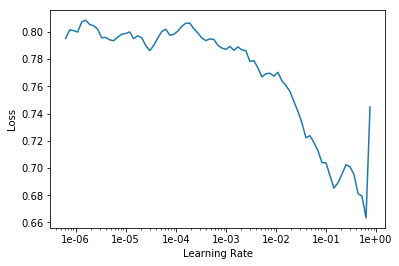

In [21]:
classifier.recorder.plot()

# Even sample between classes

In [25]:
classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.644510,0.473485,0.802000,16:05


In [26]:
classifier.save('even-reports')

In [11]:
classifier.load('even-reports')

In [28]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(2, slice(2e-2/(2.6**4),2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.650925,0.526064,0.762000,16:35
1,0.615556,0.491560,0.774000,16:42


In [29]:
classifier.save('even-reports1')

In [30]:
classifier.load('even-reports1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj school report xxmaj moreton xxmaj community xxmaj school xxmaj old xxmaj fallings xxmaj lane xxunk xxmaj xxunk xxunk xxmaj wolverhampton xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj june xxunk xxmaj overall effectiveness xxmaj previous inspection xxunk xxmaj xxunk improvement xxunk xxmaj this inspection xxunk xxmaj good xxunk xxmaj achievement of pupils xxmaj good xxunk xxmaj quality of teaching xxmaj good xxunk xxmaj behaviour and safety of pupils xxmaj good xxunk xxmaj leadership and management xxmaj good xxunk xxmaj summary of key findings for parents and pupils xxmaj this is a good school xxunk xxunk xxmaj students make good progress from their low starting points xxunk xxmaj disabled students xxunk those with special educational needs and those for whom additional funding provides extra support make better progress than these groups nationally xxunk xxunk xxmaj students show

# Uneven sample between classes

In [32]:
classifier.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.400123,0.345092,0.886000,21:32


In [33]:
classifier.save('last-reports1-july30')

In [34]:
classifier.load('last-reports1-july30')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

In [35]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.386272,0.356741,0.884000,19:11


In [36]:
classifier.save('last-reports2-july29')

In [12]:
classifier.load('last-reports2-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

In [13]:
preds = classifier.get_preds()

In [53]:
classifier.data.classes

['last', 'not_last']

In [14]:
not_last_prob = [prob[1].item() for prob in preds[0]] 
# Get the probability that it's nota last report

In [15]:
last_prob = [prob[0].item() for prob in preds[0]]

In [82]:
from sklearn.metrics import average_precision_score
average_precision_score(preds[1],not_last_prob) # avg precision if it's not last

0.9667174566352743

In [17]:
classifier.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.321394,0.344507,0.882000,07:00
1,0.331036,0.330025,0.882000,06:32
2,0.328994,0.324024,0.882000,06:24
3,0.326688,0.328477,0.884000,06:47


In [20]:
classifier.save('last-reports3-july29')

In [21]:
classifier.load('last-reports2-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

In [22]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.341179,0.319667,0.882000,07:01
1,0.327932,0.372058,0.872000,07:16


In [45]:
file = open('text-only/testing-files/2615997.txt','r').read()
classifier.predict(file) # should be a final report

(Category last, tensor(0), tensor([0.6858, 0.3142]))

In [46]:
file2 = open('text-only/testing-files/937333.txt','r').read() 
classifier.predict(file2) # Should not be a final report

(Category not_last, tensor(1), tensor([0.1163, 0.8837]))

In [47]:
import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(classifier)

In [48]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxup combined xxup inspection xxup reporturn xxunk xxmaj number xxunk xxup xxunk detailsinspection xxmaj date xxunk xxunk xxunk xxunk xxunk xxmaj name xxmaj liz xxunk detailsday xxmaj care xxmaj type xxmaj full xxmaj day caresetting xxmaj name xxmaj two xxmaj willows xxmaj early xxmaj years xxmaj centre xxunk xxmaj community centresetting xxmaj address xxmaj cardinal xxunk xxunk xxup xxunk xxup provider detailsname xxmaj early xxmaj years xxunk detailsname xxmaj,not_last,not_last,8.25,1.00
xxbos xxup tsc xxmaj report templatet r a i n i n g s t a n d a r d s c o u n c i xxup li n s p e c t i o n r e p o r t n o v e m b e r xxunk 9 9 xxup xxunk e i n s p e c t i o n f,not_last,not_last,8.07,1.00
xxbos xxunk xxmaj steiner schoolindependent school progress reportdcsf registration number xxunk xxunk xxunk xxmaj reference xxmaj number xxunk xxup urn xxunk xxunk number xxunk dates 8 xxmaj june xxunk inspector xxmaj mick xxunk xxunk xxmaj june xxunk xxmaj office for xxmaj standards in xxmaj education xxunk xxmaj children xxunk xxmaj services and xxmaj skills xxunk xxmaj ofsted xxunk regulates and inspects to achieve excellence in the care of children and,not_last,last,3.99,0.02
xxbos xxmaj school report xxmaj xxunk xxmaj primary xxmaj school xxmaj xxunk xxmaj road xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj merseyside xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj march xxunk xxmaj overall effectiveness xxmaj good xxmaj effectiveness of leadership and management xxmaj outstanding xxmaj quality of teaching xxunk learning and assessment xxmaj good xxmaj personal development xxunk behaviour and welfare xxmaj outstanding xxmaj outcomes for pupils,not_last,not_last,3.82,0.98
xxbos xxmaj la xxmaj xxunk xxmaj school xxmaj independent school standard inspection report dfe registration number xxunk xxunk xxunk xxmaj unique xxmaj reference xxmaj number xxunk xxup urn xxunk xxunk xxup urn for registered childcare xxup xxunk xxmaj inspection number xxunk xxmaj inspection dates xxunk xxmaj december xxunk xxmaj reporting inspector xxmaj flora xxmaj bean xxmaj the xxmaj office for xxmaj standards in xxmaj education xxunk xxmaj children xxunk xxmaj,not_last,not_last,3.74,0.98
xxbos xxunk xxunk xxmaj st xxmaj mary xxmaj church of englandprimary xxunk xxmaj reference xxunk xxunk xxunk xxmaj november xxunk xxunk yatesreporting inspectorthis inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk addressprimarytype of xxunk xxunk xxunk aidedschool xxunk xxunk xxup xxunk xxunk range of xxunk xxunk numbermixedgender of xxunk xxunk xxunk on roll xxunk xxunk xxmaj peter xxunk governing bodyappropriate,not_last,not_last,3.66,0.97
xxbos xxmaj ofsted xxmaj piccadilly xxmaj gate xxmaj store xxmaj street xxmaj manchester xxup xxunk xxup xxunk t xxunk xxunk xxunk xxunk xxunk ofsted xxunk xxmaj october xxunk xxmaj anthony xxmaj thomas xxmaj headteacher xxmaj edwalton xxmaj primary xxmaj school xxmaj wellin xxmaj lane xxmaj edwalton xxmaj nottingham xxmaj xxunk xxup xxunk xxup xxunk xxmaj dear xxmaj mr xxmaj thomas xxmaj short inspection of xxmaj edwalton xxmaj primary xxmaj school,not_last,last,3.46,0.03
xxbos xxmaj kidzone xxmaj astley xxmaj xxunk xxmaj stephens c of e xxmaj primary xxmaj school xxunk xxmaj manchester xxmaj road xxunk xxmaj astley xxunk xxmaj tyldesley xxunk xxmaj manchester xxunk xxup xxunk xxup xxunk xxmaj inspection date xxmaj previous inspection date xxunk xxmaj february xxunk xxunk xxmaj september xxunk xxmaj the quality and standards of the early years provision xxmaj this inspection xxunk xxmaj not met xxmaj previous inspection,not_last,not_last,3.44,0.97
xxbos xxmaj school report xxmaj the xxmaj cedar xxmaj centre xxmaj xxunk xxmaj close xxunk xxmaj xxunk xxunk xxmaj brighton xxunk xxmaj east xxmaj sussex xxunk xxup xxunk xxup xxunk xxmaj inspection dates xxunk xxmaj november xxunk xxmaj overall effectiveness xxmaj previous inspection

In [49]:
txt_ci.show_intrinsic_attention(file,cmap=cm.Purples)

In [50]:
txt_ci.show_intrinsic_attention(file2,cmap=cm.Purples)

In [23]:
classifier.save('last-reports4-july29')

In [24]:
classifier.load('last-reports4-july29')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1500 items)
x: TextList
xxbos xxmaj xxunk xxmaj primary xxmaj school xxmaj inspection report xxmaj unique xxmaj reference xxmaj number xxunk xxmaj local xxmaj authority xxmaj bradford xxmaj inspect ion number xxunk xxmaj inspect ion dates xxunk xxmaj january xxunk xxmaj report ing inspector xxmaj sarah xxmaj drake xxmaj this inspection of the school was carried out under section 5 of the xxmaj education xxmaj act xxunk xxunk xxmaj type of school xxmaj primary xxmaj school category xxmaj community xxmaj age range of pupils xxunk xxmaj gender of pupils xxmaj mixed xxmaj number of pupils on the school roll xxunk xxmaj appropriate authority xxmaj the governing body xxmaj xxunk xxmaj mrs xxmaj jo xxmaj ryder xxunk xxmaj xxunk xxmaj headteacher xxmaj mr xxmaj malcolm xxmaj campbell xxmaj date of previous school inspection 4 xxmaj october xxunk xxmaj school address xxmaj xxunk xxmaj mount xxmaj xxunk xxunk xxmaj bradford xxmaj west xxmaj x

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


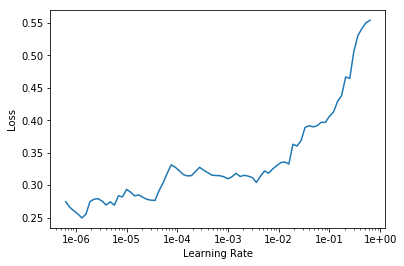

In [53]:
# More training
classifier.lr_find()
classifier.recorder.plot()

In [25]:
# Choose a learning rate at train it for 4 epochs
classifier.freeze_to(-2)
classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.329040,0.340213,0.868000,06:59
1,0.308030,0.342456,0.884000,07:16


In [33]:
classifier.export('/picstorage/export.pkl') 

In [58]:
# Add to print out words that the classifier gains the most info from
idx = 4
print(classifier.predict(str(classifier.data.valid_ds.x[idx])))
txt_ci.show_intrinsic_attention(classifier.data.valid_ds.x[idx],cmap=cm.Purples)

(Category not_last, tensor(1), tensor([0.0239, 0.9761]))


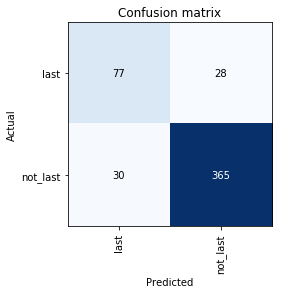

In [59]:
from fastai.vision import ClassificationInterpretation
interp2 = ClassificationInterpretation.from_learner(classifier)
interp2.plot_confusion_matrix()

In [71]:
preds = classifier.get_preds()

In [81]:
len(preds[0])
len(preds[1])
len(classifier.data.valid_ds)

500

500

500

In [27]:
classifier.data.classes

['last', 'not_last']

In [73]:
not_last_prob = [prob[1].item() for prob in preds[0]] 
# Get the probability that it's nota last report

In [74]:
last_prob = [prob[0].item() for prob in preds[0]]

In [75]:
from sklearn.metrics import recall_score
average_precision_score(preds[1],not_last_prob) # avg precision if it's not last

0.9541119363872355

In [76]:
average_precision_score(preds[1],last_prob,pos_label=0) # avg precision if it's last

0.7703928854813565

In [46]:
pred_labels = [classifier.predict(i)[0].obj for i in classifier.data.valid_ds.x]

In [52]:
recall_preds = [0 if i=='last' else 1 for i in pred_labels]

In [65]:
recall_labels = [i.obj for i in classifier.data.valid_ds.y]
recall_labels = [0 if i=='last' else 1 for i in recall_labels]

In [68]:
from sklearn.metrics import recall_score
recall_score(recall_labels,recall_preds)

0.9265822784810127